# Work with transformations in a notebook



In [1]:

import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
warnings.filterwarnings("ignore")

# add SISEPUEDE to path
dir_py = pathlib.Path(os.path.realpath(".")).parents[0].joinpath("python")
if str(dir_py) not in sys.path:
    sys.path.append(str(dir_py))

# import the define_transformations objects
import define_transformations_afolu as dta
import define_transformations_circular_economy as dtc
import define_transformations_energy as dte
import define_transformations_ippu as dti
import define_transformations_integrated as dtr

# get other SISEPUEDE objects
import sisepuede as ssp
import sisepuede_file_structure as sfs
import sisepuede_models as sm
import support_classes as sc
import support_functions as sf

#import transformations_base_afolu as tba
#mport transformations_base_circular_economy as tbc
#import transformations_base_energy as tbe
#import transformations_base_general as tbg
#import transformations_base_ippu as tbi


MISSIONSEARCHNOTE: As of 2023-10-06, there is a temporary solution implemeted in ModelAttributes.get_variable_to_simplex_group_dictionary() to ensure that transition probability rows are enforced on a simplex.

FIX THIS ASAP TO DERIVE PROPERLY.


##  Initialize the SISEPUEDE class to get data from existing templates
- see ``?SISEPUEDE`` for more information on initialization arguments
- You can initialize as a dummy to avoid marginal setup time for Julia, but we may want to run with it at some point

In [3]:
sisepuede = ssp.SISEPUEDE(
    "calibrated",
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    #n_futures = 100,
    regions = ["peru"],
    try_exogenous_xl_types_in_variable_specification = True,
)

MISSIONSEARCHNOTE: As of 2023-10-06, there is a temporary solution implemeted in ModelAttributes.get_variable_to_simplex_group_dictionary() to ensure that transition probability rows are enforced on a simplex.

FIX THIS ASAP TO DERIVE PROPERLY.


2024-05-20 12:02:29,595 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-05-20 12:02:29,598 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-05-20 12:02:29,599 - INFO - 	Setting export engine to 'sqlite'.
2024-05-20 12:02:29,624 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2024-05-20 12:02:29,625 - INFO - Successfully instantiated table ANALYSIS_METADATA
2024-05-20 12:02:29,626 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2024-05-20 12:02:29,627 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2024-05-20 12:02:29,629 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2024-05-20 12:02:29,630 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2024-05-20 12:02:29,632 - WARNING - No index

In [5]:
sisepuede.model_attributes.get_dimensional_attribute_table("design_id")

,design_id,vary_l,vary_x,linear_transform_l_m,linear_transform_l_b,linear_transform_l_inf,linear_transform_l_sup,design_name,include
0,0,0,1,1.00,0.00,1.00,1,Vary Xs (design 0),1
1,1,1,1,0.75,0.25,0.25,1,Vary Xs and Les; Cap LE at 1 (design 1),1
2,2,1,1,1.25,0.00,0.25,1,"Vary Xs and LEs; Cap LE at 1.1 (design 2, 20% ...",1
3,3,1,0,0.90,0.10,0.10,1,Vary LEs; (design 3),1


In [6]:
sisepuede.project_scenarios(
    {
        "design_id": 3,
        "strategy_id": 7002,
    }
)

TypeError: 'int' object is not iterable

# Now, generate a baseline input dataframe to work from
- You can use what you want; `sisepuede.baseline_strategy` stores the id for baseline strategy, but you may want to compare to another baseline

In [7]:
primary_base = sisepuede.odpt_primary.get_key_value(
    **{
        "design_id": 0,
        "future_id": 0,
        "strategy_id": 0 # Land Use with PLUR
    }
)
df_in = sisepuede.generate_scenario_database_from_primary_key(primary_base);
df_in = df_in.get("peru")

###  Let's do some evaluation without leveraging the entire SISEPUEDE framwork--just using the models
- we can read a data frame and return a dataframe
- we can also interact with transformations in the notebook and evaluate how they work together

In [16]:
mod = sisepuede.models

In [39]:
?mod.project

Signature:
mod.project(
    df_input_data: pandas.core.frame.DataFrame,
    check_results: bool = True,
    fields_check: Union[List[str], str, NoneType] = 'emissions_output_subsector_aggregate',
    include_electricity_in_energy: bool = True,
    models_run: Optional[List[str]] = None,
    regions: Union[List[str], str, NoneType] = None,
    run_integrated: bool = True,
    time_periods_run: Optional[List[int]] = None,
    **kwargs,
) -> pandas.core.frame.DataFrame
Docstring:
Execute the SISEPUEDE DAG.

Function Arguments
------------------
df_input_data: DataFrame containing SISEPUEDE inputs

Optional Arguments
------------------
- models_run: list of sector models to run as defined in
        SISEPUEDEModels.model_attributes. Can include the following values:

        * AFOLU (or af)
        * Circular Economy (or ce)
        * IPPU (or ip)
        * Energy (or en)
                * Note: set include_electricity_in_energy = False to avoid
                        running the electric

<AxesSubplot: xlabel='time_period'>

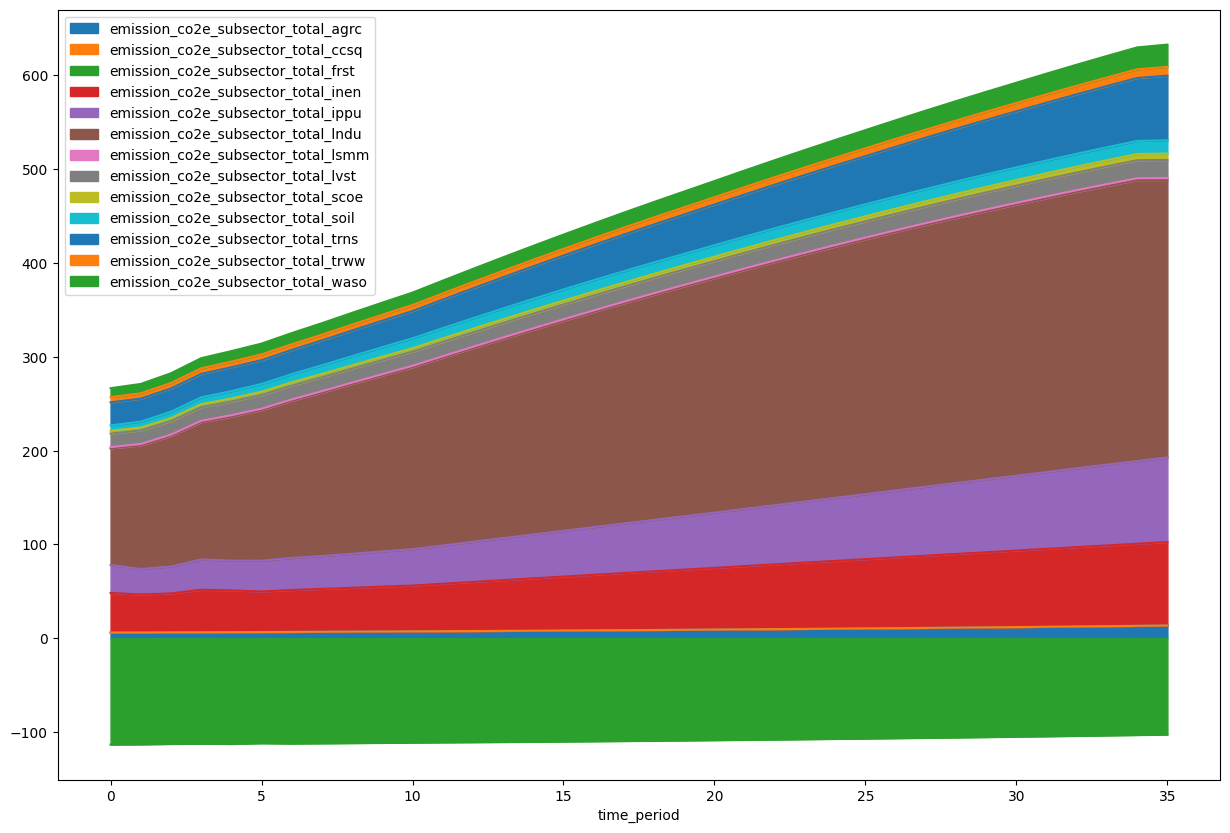

In [19]:
def plot_emissions(
    df: pd.DataFrame,
) -> plt.plot:
    """
    This is a docstring. Returns a Matplotlib plot
    
    Function Arguments
    ------------------
    - df: data frame to plot
    """
    
    fields_emissions = [
        x for x in df.columns if x.startswith("emission_co2e_subsector_total")
    ]
    
    fig, ax = plt.subplots(figsize = (15, 10))
    plot_out = (
        df[
            [sisepuede.key_time_period] + fields_emissions
        ]
        .plot
        .area(
            x = sisepuede.key_time_period,
            ax = ax,
        )
    )
    
    
    return plot_out


plot_emissions(df_out)

In [13]:
?plot_emissions

Signature: plot_emissions(df: pandas.core.frame.DataFrame) -> <function plot at 0x1128b3c40>
Docstring:
This is a docstring. Returns a Matplotlib plot

Function Arguments
------------------
- df: data frame to plot
File:      /var/folders/8m/3ll2cn6d1hdcs6gjqxr2jx5d2hffc9/T/ipykernel_91678/98077837.py
Type:      function


##  Now lets's think about some transformations
- Currently, some configuration pieces relevant to transformations have to be set in a dictionary. **This is soon changing**, but you can see below  how to instantiate a transformations object

In [14]:
year_0_ramp = 2025

# set some parameters (WILL SET TO READ FROM A CONFIG OR STRATEGY DEFINITION FILE)
dict_config_te = {
    "categories_entc_max_investment_ramp": [
        "pp_hydropower"
        #"pp_nuclear"
    ],
    "categories_entc_renewable": [
        "pp_geothermal",
        "pp_hydropower",
        "pp_ocean",
        "pp_solar",
        "pp_wind"
    ],
    "categories_inen_high_heat": [
        "cement", 
        "chemicals", 
        "glass", 
        "lime_and_carbonite", 
        "metals"
    ],
    "dict_entc_renewable_target_msp": {
        "pp_solar": 0.15,
        "pp_geothermal": 0.1,
        "pp_wind": 0.15
    },
    "frac_inen_high_temp_elec_hydg": 0.5*0.45,
    "frac_inen_low_temp_elec": 0.95*0.45,
    "n_tp_ramp": None,
    "vir_renewable_cap_delta_frac": 0.0075,
    "vir_renewable_cap_max_frac": 0.125,
    "year_0_ramp": year_0_ramp
}


transformations_integrated = dtr.TransformationsIntegrated(
    dict_config_te,
    baseline_with_plur = False, # SET TO TRUE TO ALLOW THE BASELINE TO INCLUDE PLUR (NULLIFIES THE WITH PLUR STRAT)
    df_input = df_in,
    field_region = sisepuede.key_region,
    regions = sisepuede.regions,
)

MISSIONSEARCHNOTE: As of 2023-10-06, there is a temporary solution implemeted in ModelAttributes.get_variable_to_simplex_group_dictionary() to ensure that transition probability rows are enforced on a simplex.

FIX THIS ASAP TO DERIVE PROPERLY.


In [17]:
df_out = mod.project(
    df_in,
    include_electricity_in_energy = False,
)

2024-05-20 12:12:16,981 - INFO - Running AFOLU model
2024-05-20 12:12:17,380 - INFO - AFOLU model run successfully completed
2024-05-20 12:12:17,381 - INFO - Running CircularEconomy model
2024-05-20 12:12:17,498 - INFO - CircularEconomy model run successfully completed
2024-05-20 12:12:17,499 - INFO - Running IPPU model
2024-05-20 12:12:17,685 - INFO - IPPU model run successfully completed
2024-05-20 12:12:17,686 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-05-20 12:12:17,735 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-05-20 12:12:17,962 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-05-20 12:12:17,963 - INFO - Running Energy (Fugitive Emissions)
2024-05-20 12:12:18,022 - ERROR - Error running Fugitive Emissions from Energy model: 
            Unable to extract variable Total Energy Demand by Fuel in extract_mode

# let's plot some emissions

<AxesSubplot: xlabel='time_period'>

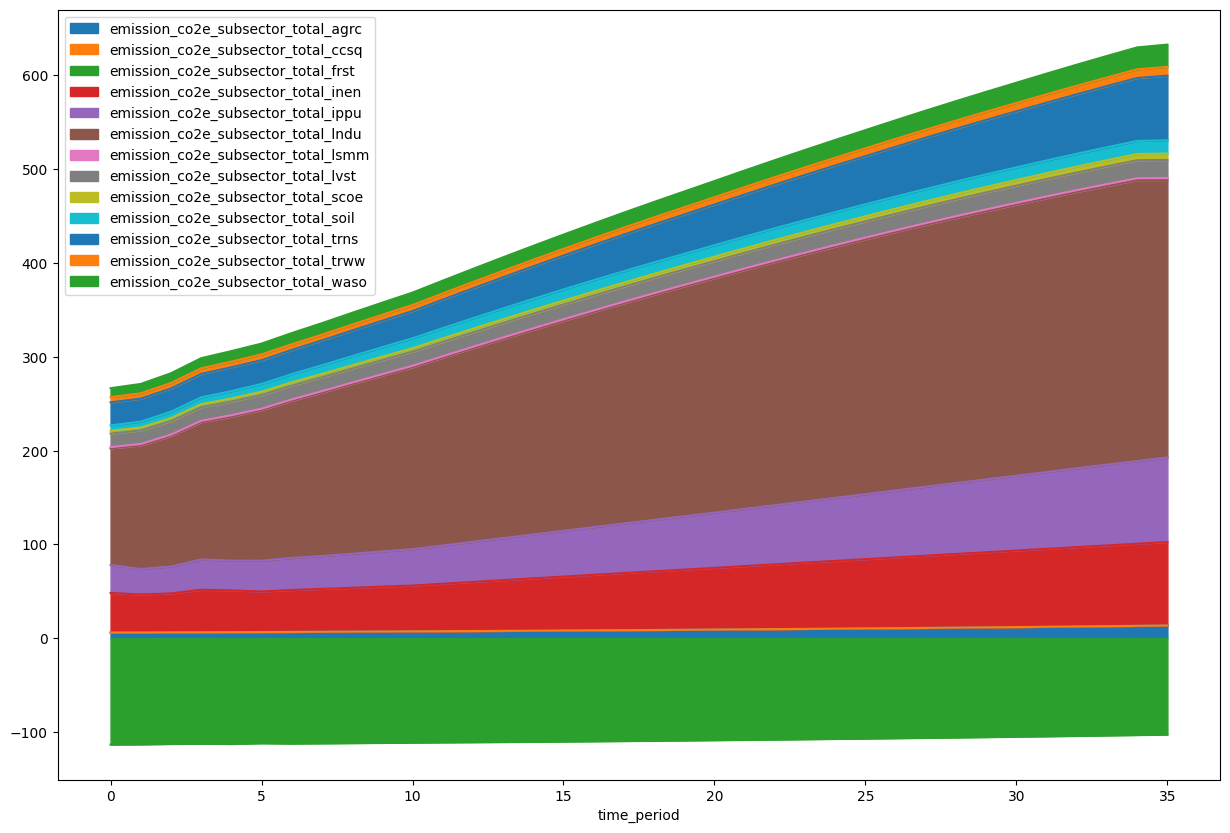

In [42]:
fields_emissions = [x for x in df_out.columns if x.startswith("emission_co2e_subsector_total")]
fig, ax = plt.subplots(figsize = (15, 10))
(
    df_out[
        [sisepuede.key_time_period] + fields_emissions
    ]
    .plot
    .area(
        x = sisepuede.key_time_period,
        ax = ax,
    )
)

In [46]:
transformations_integrated.get_strategy(1015)

In [32]:
df_in_st = transformations_integrated.pflo_sociotechnical()

In [33]:
df_out_st = mod.project(
    df_in_st,
    include_electricity_in_energy = False,
)

2024-05-17 12:08:13,060 - INFO - Running AFOLU model
2024-05-17 12:08:13,060 - INFO - Running AFOLU model
2024-05-17 12:08:13,433 - INFO - AFOLU model run successfully completed
2024-05-17 12:08:13,433 - INFO - AFOLU model run successfully completed
2024-05-17 12:08:13,434 - INFO - Running CircularEconomy model
2024-05-17 12:08:13,434 - INFO - Running CircularEconomy model
2024-05-17 12:08:13,528 - INFO - CircularEconomy model run successfully completed
2024-05-17 12:08:13,528 - INFO - CircularEconomy model run successfully completed
2024-05-17 12:08:13,530 - INFO - Running IPPU model
2024-05-17 12:08:13,530 - INFO - Running IPPU model
2024-05-17 12:08:13,711 - INFO - IPPU model run successfully completed
2024-05-17 12:08:13,711 - INFO - IPPU model run successfully completed
2024-05-17 12:08:13,712 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-05-17 12:08:13,712 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-05-17 1

<AxesSubplot: xlabel='time_period'>

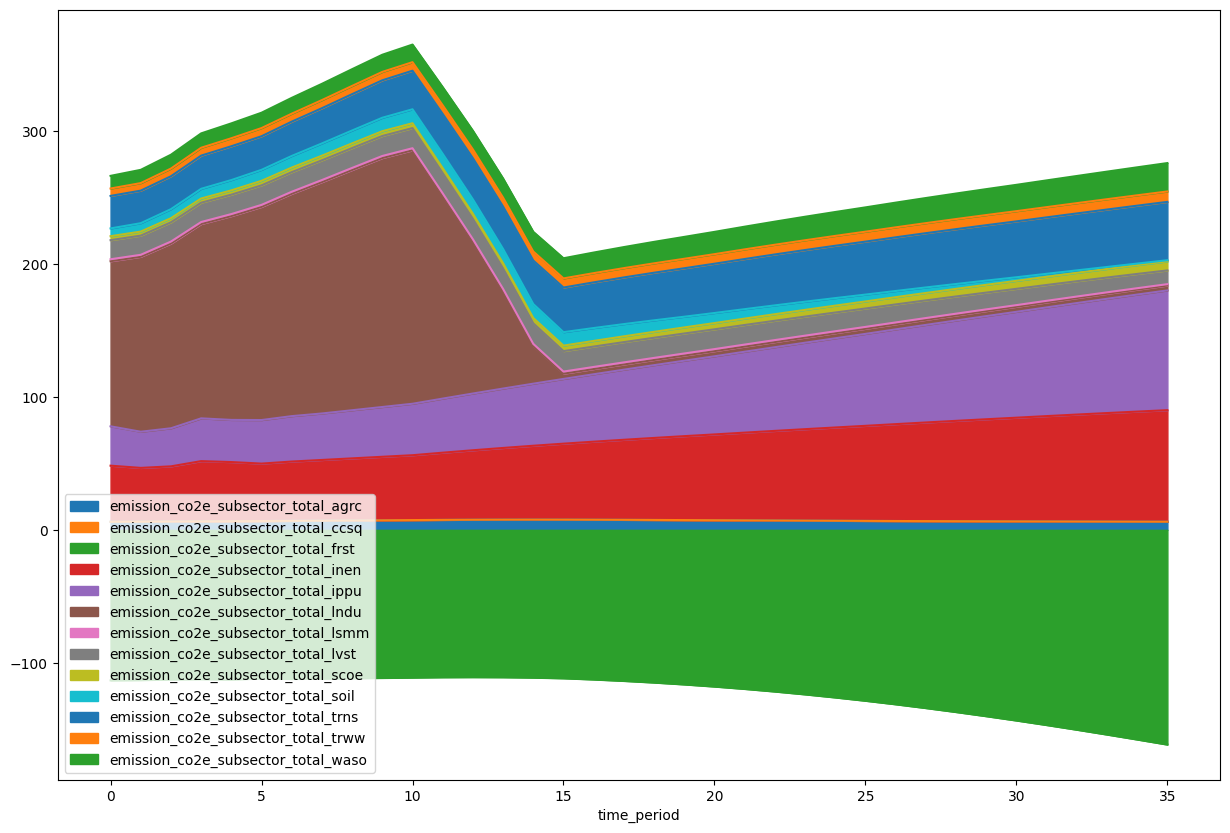

In [34]:
# sisepuede.model_attributes.get_dimensional_attribute_table("strategy_id").table.tail()
fields_emissions = [x for x in df_out_st.columns if x.startswith("emission_co2e_subsector_total")]
fig, ax = plt.subplots(figsize = (15, 10))

(
    df_out_st[
        [sisepuede.key_time_period] + fields_emissions
    ]
    .plot
    .area(
        x = sisepuede.key_time_period,
        ax = ax,
    )
)

# use the `transformations_integrated` to build an input Excel file for strategies you want to keep
- There are a few ways to do this; you can use strategy codes, names, or IDs
- Look at the attribute table below; shows rows from 121 to end. Can scan locations for ids to keep if you don't know what they are

In [211]:
# show some available strategies (btw, .iloc gives the row index; `.iloc[120:]` gives the 121st row the end)
sisepuede.model_attributes.get_dimensional_attribute_table("strategy_id").table.iloc[120:]

,strategy_id,strategy,strategy_code,baseline_strategy_id,description
120,5001,PFLO: Better baseline,PFLO:BETTER_BASE,0,"Business as usual, but done better. Does not i..."
121,5002,PFLO: Healthier diets,PFLO:BETTER_DIETS,0,Reduce the fraction of the population eating r...
122,5003,PFLO: Healthier diets with partial land use re...,PFLO:BETTER_DIETS_PLUR,0,Reduce the fraction of the population eating r...
123,5004,PFLO: Change consumer behavior,PFLO:CHANGE_CONSUMPTION,0,Sweeping changes to consumer behavrior and soc...
124,5005,PFLO: Industrial point of capture CCSQ,PFLO:IND_INC_CCS,0,Specifies point-of-capture carbon capture and ...
125,5006,PFLO: Supply side technologies and transformat...,PFLO:SUPPLY_SIDE_TECH,0,Macro-scale transformations without consumer b...
126,5007,PFLO: All transformations without stopping def...,PFLO:ALL_NO_STOPPING_DEFORESTATION_PLUR,0,All transformations and partial land use reall...
127,5008,PFLO: All transformations,PFLO:ALL,0,All transformations
128,5009,PFLO: All transformations with partial land us...,PFLO:ALL_PLUR,0,All transformations
129,5010,PFLO: All transformations with partial land us...,PFLO:ALL_PLUR_NO_SILVOPASTURE,0,All transformations except for silvopasture


In [25]:
# for now, it's easiest to just set the strategy ids you want to write in a list, then specify it 
#
#  ALSO, NIDHI, I NEED TO SEND YOU A FILE FOR VAR_GROUPS TO ENSURE THAT THE VARIABLES SHARE THE CORRECT LHS TRIAL
#
strategies_keep = [0, 1015, 5009] # you would change 5009 to the PERU NDC id you specified

transformations_integrated.build_strategies_to_templates(
    include_simplex_group_as_trajgroup = True, # passed to input_template.template_from_inputs()
    strategies = strategies_keep,
)


0

# Once the transformations build to templates successully, you can re-initialize the SISEPUEDE object. It will load the latest data available and should do it without having to re-compile the Julia code

In [26]:
# this will create a new output database
sisepuede = ssp.SISEPUEDE(
    "calibrated",
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    n_trials = 10, # IMPORTANT--set this to the number of trials to you want to run
    regions = ["peru"],
    try_exogenous_xl_types_in_variable_specification = True,
)

MISSIONSEARCHNOTE: As of 2023-10-06, there is a temporary solution implemeted in ModelAttributes.get_variable_to_simplex_group_dictionary() to ensure that transition probability rows are enforced on a simplex.

FIX THIS ASAP TO DERIVE PROPERLY.


2024-05-20 12:24:04,485 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-05-20 12:24:04,485 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-05-20 12:24:04,492 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-05-20 12:24:04,492 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-05-20 12:24:04,494 - INFO - 	Setting export engine to 'sqlite'.
2024-05-20 12:24:04,494 - INFO - 	Setting export engine to 'sqlite'.
2024-05-20 12:24:04,502 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2024-05-20 12:24:04,502 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2024-05-20 12:24:04,504 - INFO - Successfully instantiated table ANALYSIS_METADATA
2024-05-20 12:24:04,504 - INFO - Succes

##  Note: you can always see the ID of the session you're working in using `sisepuede.id`

In [215]:
sisepuede.id

'sisepuede_run_2024-05-20T12:24:02.783556'

##  You can examine the design ids here
- Note that only `design_id = 3` does not vary Xs, but LEs alone (LEs are technically Xs, but they are the Xs for a lever's true effect)

In [214]:
sisepuede.model_attributes.get_dimensional_attribute_table("design_id")

,design_id,vary_l,vary_x,linear_transform_l_m,linear_transform_l_b,linear_transform_l_inf,linear_transform_l_sup,design_name,include
0,0,0,1,1.00,0.00,1.00,1,Vary Xs (design 0),1
1,1,1,1,0.75,0.25,0.25,1,Vary Xs and Les; Cap LE at 1 (design 1),1
2,2,1,1,1.25,0.00,0.25,1,"Vary Xs and LEs; Cap LE at 1.1 (design 2, 20% ...",1
3,3,1,0,0.90,0.10,0.10,1,Vary LEs; (design 3),1


##  Note on Xs and LEs
- Both are LHC trials. Xs are associated with LHC trials associated with exogenous uncertainties, while LEs are associated with Lever Effects
- A hypotehtical matrix of LHC trials might look like

$
X = \left(
\begin{array}{ccccccc}
x^{(g)}_{11} & x^{(g)}_{12} & \ldots & x^{(g)}_{1n} & x^{(l)}_{1,n+1} & \ldots & x^{(l)}_{1,n+m}\\
x^{(g)}_{21} & x^{(g)}_{22} & \ldots & x^{(g)}_{21} & x^{(l)}_{2,n+1} & \ldots & x^{(l)}_{2,n+m}\\
\vdots \\
x^{(g)}_{T1} & x^{(g)}_{T2} & \ldots & x^{(g)}_{T1} & x^{(l)}_{T,n+1} & \ldots & x^{(l)}_{T,n+m}
\end{array}
\right)
$

where

- $T$ is the number of LHS trials, and row $i$ of $X$ corresponds with `future_id = i`, $1 \leq i \leq T$
    - `future_id = 0` is always the nominal assumption about the future state
- $x^{(g)}_{ij}$ is the LHS trial associated with **exogenous uncertainty** $j$ and `future_id = i`, $1 \leq j \leq n$ for $n$ exogenous uncertainties
- $x^{(l)}_{i,n + j}$ is the LHS trial associated with **lever effect uncertainty** $j$ and `future_id = i`, $1 \leq j \leq m$ for $m$ lever effect uncertainties

The matrix $X$ is fixed for a given instantiation of SISEPUEDE and can be governed by a random seed for reproducability (set in configuration or in instantiation of `SISEPUEDE`)

##  Allowing LEs to vary but no Xs will explore over lever effects (LEs) while fixing baseline assumptions about exogenous uncertainties
- This is the lever uncertainties experiment
- Specify the strategies that you want to explore LEs over
- Futures are LHS trials

In [27]:
# Just call the object to run the model. Will populate to new output database
sisepuede(
    {
        #"future_id": [0, 222, 352, 851, 911], # ranges from 0 - sisepuede.n_trials
        "design_id": [3],
        "strategy_id": [5009] # specify the Peru 
    },
    chunk_size = 3, # how often to write to output database
    regions = ["peru"], # optional specification of regions to run; if unspecified, will run all regions defined in sisepude.regions, which are those set on instantiation
    save_inputs = True, # defaults to False, but for small designs, can be convenient
)

Signature:
sisepuede.project_scenarios(
    primary_keys: Union[List[int], Dict[str, int], NoneType],
    check_results: bool = True,
    chunk_size: int = 10,
    force_overwrite_existing_primary_keys: bool = False,
    max_attempts: int = 2,
    regions: Union[List[str], str, NoneType] = None,
    reinitialize_output_table_on_verification_failure: bool = False,
    save_inputs: Optional[bool] = None,
    skip_nas_in_input: bool = False,
    **kwargs,
) -> List[int]
Docstring:
Project scenarios forward for a set of primary keys. Returns the set of
        primary keys that ran successfully.

Function Arguments
------------------
- primary_keys: list of primary keys to run OR dictionary of index keys 
        (e.g., strategy_id, design_id) with scenarios associated as values 
        (uses AND operation to filter scenarios). If None, returns all 
        possible primary keys.

Keyword Arguments
-----------------
- check_results: check output results when running? If True, verifies
   

In [217]:
dir(sisepuede.model_attributes)

?sisepuede.model_attributes.build_variable_dataframe_by_sector

Signature:
sisepuede.model_attributes.build_variable_dataframe_by_sector(
    sectors_build: Union[List[str], str, NoneType],
    df_trajgroup: Optional[pandas.core.frame.DataFrame] = None,
    field_subsector: str = 'subsector',
    field_variable: str = 'variable',
    field_variable_trajectory_group: str = 'variable_trajectory_group',
    include_simplex_group_as_trajgroup: bool = False,
    include_time_periods: bool = True,
    vartype: str = 'input',
) -> pandas.core.frame.DataFrame
Docstring:
Build a data frame of all variables long by subsector and variable.
    Optional includion of time_periods.

Function Arguments
------------------
- sectors_build: sectors to include subsectors for

Keyword Arguments
-----------------
- df_trajgroup: optional dataframe mapping each field variable to 
    trajectory groups. 
    * Must contain field_subsector, field_variable, and 
        field_variable_trajectory_group as fields
    * Overrides include_simplex_group_as_trajgroup if specifie

In [218]:
[x for x in dir(sisepuede.model_attributes) if "sampling_range" in x]

['build_default_sampling_range_df']

# Temporary code to build data for Steven and Rob

In [ ]:
sisepuede2 = ssp.SISEPUEDE(
    "calibrated",
    initialize_as_dummy = True,
    regions = ["brazil"],
)

dict_out = sisepuede2.generate_scenario_database_from_primary_key(0)


In [293]:
df_sg = pd.read_csv("/Users/jsyme/Documents/Projects/git_jbus/sdexplorer/ref/variable_specification_to_sample_group.csv")

"""
df_ranges = sisepuede.model_attributes.build_default_sampling_range_df()

df_ranges.rename(
    columns = {
        "variable": "variable_specification",
        "min_35": "min_scalar",
        "max_35": "max_scalar"
    },
    inplace = True,
)

if "min_scalar" not in df_sg.columns:
    df_sg_out = (
        pd.merge(
            df_sg,
            df_ranges,
            how = "left",
        )
        .fillna(1.0)
    )
"""

##  GET ALL INFO

tab = sisepuede.model_attributes.get_dimensional_attribute_table("time_period")
tp_max = max(tab.key_values)
yr_max = tab.get_attribute(tp_max, "year")

# get the experimental manager and future trajectories
ft = sisepuede2.experimental_manager.dict_future_trajectories.get("brazil")

df_out = []
fields_ext = ["variable", f"min_{tp_max}", f"max_{tp_max}", tp_max]

for k, v in ft.dict_sampling_units.items():
    
    df = v.df_variable_definitions
    df = df[
        df[sisepuede.key_strategy].isin([sisepuede.baseline_strategy])
    ]
    
    for i, row in df.iterrows():
        df_out.append([row.get(x) for x in fields_ext])

df_out = pd.DataFrame(df_out, columns = fields_ext)
    
    
"""
df = (
    df[
        df[sisepuede.key_time_period].isin([tp_max])
    ]
    .transpose()
    .reset_index()
    .rename(
        columns = {
            tp_max: f"nominal_{yr_max}",
            "inderx": "variable_specification",
        }
    )
)
"""  

df_sg_out = (
    pd.merge(
        df_sg_out[["variable_specification", "sample_group"]],
        df_out.rename(
            columns = {
                "variable": "variable_specification",
                f"min_{tp_max}": "min_scalar", 
                f"max_{tp_max}": "max_scalar", 
                tp_max: f"nominal_{yr_max}"
            }
        ),
        how = "left"
    )
    #.fillna(1.0)
)

In [296]:
df_sg_out.to_csv(
    "/Users/jsyme/Documents/Projects/git_jbus/sdexplorer/ref/variable_specification_to_sample_group.csv",
    index = None,
    encoding = "UTF-8",
)

In [273]:
su = ft.dict_sampling_units.get(1)

In [297]:
df_pt = pd.read_csv("/Users/jsyme/Documents/Projects/git_jbus/sdexplorer/ref/pt_clean.csv")
df_vs = pd.read_csv("/Users/jsyme/Documents/Projects/git_jbus/sdexplorer/ref/variable_specification_to_sample_group.csv")

In [307]:
flds = [x for x in df_pt.columns if x.startswith("X") and x.endswith("_drivers")]
sgs = [int(x.replace("X", "").replace("_drivers", "")) for x in flds]

(
    df_vs[
        df_vs["sample_group"].isin(sgs)
    ]
    .sort_values(by = ["sample_group", "variable_specification"])
    .reset_index(drop = True)
    .to_csv(
        "/Users/jsyme/Desktop/tmp_group_desc.csv",
        index = None,
        encoding = "UTF-8",
    )
)

In [314]:
df_scalar_groups = pd.read_csv("/Users/jsyme/Desktop/tmp_group_desc.csv")

In [317]:
df_sg_attribute = (
    df_scalar_groups[["sample_group", "sample_group_names"]]
    .drop_duplicates()
    .sort_values(by = ["sample_group"])
    .reset_index(drop = True)
    .rename(columns = {"sample_group_names": "descriptive_field"})
)

df_sg_attribute.to_csv(
    "/Users/jsyme/Documents/Projects/git_jbus/sdexplorer/ref/attribute_sample_group.csv",
    index = None,
    encoding = "UTF-8"
)